In [9]:
FILE_PATH = '/Users/tony/Desktop/podslushano_texts/'

In [443]:
import numpy as np
import tqdm
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (8, 8)
import seaborn as sns
import pickle
import os
import torch
import torch.optim as optim
from torch import nn
import torch.nn.functional as F
import os
import json
import torchtext
import pymorphy2
import time

In [17]:
dat = json.load(open(os.path.join(FILE_PATH, 'podslushano_104k_texts'), mode='r', encoding='utf-8'))


Рассмотрим примеры текстов с тегами

In [22]:
for i in dat[:5]:
    print(i[0])
    print(i[1])
    print('')

Чернуха
Рассказал подруге о своей первой любви. Всё как по канону: влюбился по самые уши, жить не могу, она прекрасна и всё такое. Так произошло, что после нашей последней встречи произошла утечка газа, взрыв, её с ожогами увезли за границу. После моего душевного рассказа подруга сказала: "Между вами мелькали искры".

Детство
У меня мало хороших воспоминаний о папе. Но это помню отлично. Мне четыре, сделала самолёт из длинного большого пинцета и плетёной детской корзинки. Самолёт должен был сесть, и я не придумала места лучше, чем розетка. Я воткнула пинцет в розетку и во всей квартире вырубился свет. Током меня не ударило. Прибежала мать, орала на меня, хотела отшлепать, но вмешался папа и сразу стал осматривать меня и спрашивать, все ли хорошо. Я очень дорожу этим воспоминанием.

Смешное
Я думаю, у каждого парня есть что-то, что заставляет охладить свое траханье. Не знаю, у кого что, а у меня это дядюшка Сталин, который почесывает усики.

Странное
Однажды ехал в троллейбусе после уни

Нормализуем тексты (примерно час времени)

In [167]:
morph = pymorphy2.MorphAnalyzer()
morph_texts_list = []
for i in tqdm.tqdm(dat):
    i[1] = re.sub(r"([\w/'+$\s-]+|[^\w/'+$\s-]+)\s*", r"\1 ", i[1])
    a = [morph.parse(j)[0].normal_form for j in i[1].split()]
    morph_texts_list.append([' '.join(a), i[0]])

100%|██████████| 104250/104250 [1:01:18<00:00, 28.34it/s]


Загрузим список стоп-слов

In [215]:
with open(os.path.join(FILE_PATH, 'stop-words-russian.txt'), mode='r', encoding='utf-8') as f:
    stop_w = f.readlines()
stop_w = [i.replace('\n', '') for i in stop_w]

Составим датафрейм для подачи в torchtext

In [223]:
dat_df = pd.DataFrame()
a = []
b = []
for i in tqdm.tqdm(morph_texts_list):
    k = ' '.join([j for j in i[0].split() if j not in stop_w])  # убираем стоп-слова
    a.append(k)
    b.append(i[1])
dat_df['texts'] = a
dat_df['tags'] = b

100%|██████████| 104250/104250 [00:40<00:00, 2572.44it/s]


In [236]:
# # Сохраняем весь датафрейм
# dat_df.to_csv(os.path.join(FILE_PATH, 'all_parsed_dataframe.csv'), index=False)

Составим train и test

In [345]:
_ = np.random.permutation(np.arange(dat_df.shape[0]))
tr_index, te_index = np.split(_, [int(np.floor(0.9*len(dat_df)))])

dat_train_df = dat_df.loc[tr_index]
dat_test_df = dat_df.loc[te_index]

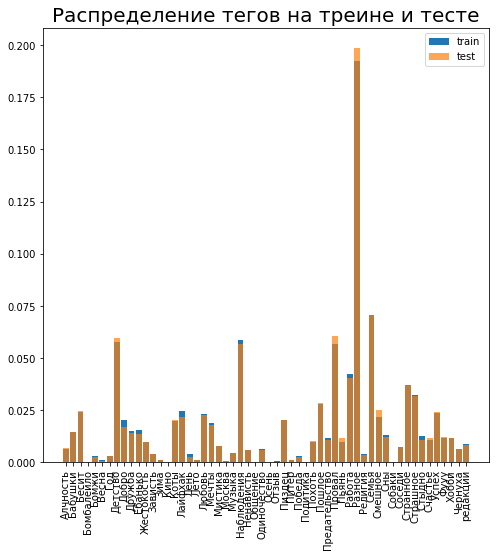

In [346]:
a, b = np.unique(dat_train_df.tags.values, return_counts=True)
plt.bar(a, b/b.sum(), label='train')
plt.xticks(np.arange(a.shape[0]), a, rotation=90);
c, d = np.unique(dat_test_df.tags.values, return_counts=True)
plt.bar(a, d/d.sum(), label='test', alpha=0.7)
plt.xticks(np.arange(a.shape[0]), a, rotation=90);
plt.title(u'Распределение тегов на треине и тесте', fontsize=20)
plt.legend();

In [354]:
# # Сохраняем треин и тест
# dat_train_df.to_csv(os.path.join(FILE_PATH, 'data_train.csv'), index=False, encoding='utf-8')
# dat_test_df.to_csv(os.path.join(FILE_PATH, 'data_test.csv'), index=False, encoding='utf-8')

Составляем препроцессоры для составление батчей

In [579]:
from torchtext.data import Field
tokenize = lambda x: x.lower().split()
TEXT = Field(sequential=True, tokenize=tokenize, lower=True)
LABEL = Field(sequential=False, use_vocab=True, tokenize=tokenize, lower=True, unk_token=None)

Составляет train и test

In [580]:
from torchtext.data import TabularDataset
 
tv_datafields = [("texts", TEXT), ("tags", LABEL)]
trn = TabularDataset(
           path=os.path.join(FILE_PATH, 'data_train.csv'), # the file path
           format='csv',
           skip_header=True, # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
           fields=tv_datafields)
 
tst_datafields = [("texts", TEXT), ("tags", LABEL)]
tst = TabularDataset(
           path=os.path.join(FILE_PATH, 'data_test.csv'), # the file path
           format='csv',
           skip_header=True, # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
           fields=tst_datafields)

 Составляем словарь

In [581]:
TEXT.build_vocab(trn, max_size=40000)
LABEL.build_vocab(trn)

Составляет батч итератор

In [582]:
from torchtext.data import Iterator, BucketIterator
BATCH = 100
train_iter = BucketIterator(trn, batch_size=BATCH, device=torch.device('cpu'), sort_key=lambda x: len(x.texts), 
                                sort_within_batch=True, repeat=False)
test_iter = BucketIterator(tst, batch_size=BATCH, device=torch.device('cpu'), sort_key=lambda x: len(x.texts), 
                                sort_within_batch=True, repeat=False)

class BatchWrapper:
    def __init__(self, dl, x_var, y_vars):
        self.dl, self.x_var, self.y_vars = dl, x_var, y_vars # we pass in the list of attributes for x and y
    
    def __iter__(self):
        for batch in self.dl:
            x = getattr(batch, self.x_var) # we assume only one input in this wrapper
            
            if self.y_vars is not None: # we will concatenate y into a single tensor
                y = torch.cat([getattr(batch, feat).unsqueeze(1) for feat in self.y_vars], dim=1).float()
            else:
                y = torch.zeros((1))

            yield (x, y)
    
    def __len__(self):
        return len(self.dl)

train_dl = BatchWrapper(train_iter, 'texts', ['tags'])
test_dl = BatchWrapper(test_iter, 'texts', ['tags'])


In [583]:
x, y = next(train_dl.__iter__())
x, y

(tensor([[  207,  4229,  5790,  ...,   712,  1189,    33],
         [   75, 12405,  6701,  ..., 26347,    44,    51],
         [   19,     0,  4574,  ...,   371,    16,   194],
         ...,
         [  500,     5, 16490,  ...,   734,   979,  7956],
         [16789, 23270,   266,  ...,   563,   134,  3155],
         [   11,    24,     7,  ...,     3,     3,     3]]), tensor([[24.],
         [ 0.],
         [23.],
         [10.],
         [ 0.],
         [ 0.],
         [ 2.],
         [ 0.],
         [ 0.],
         [ 4.],
         [ 0.],
         [ 7.],
         [23.],
         [27.],
         [ 0.],
         [11.],
         [ 0.],
         [ 9.],
         [17.],
         [ 5.],
         [ 3.],
         [ 5.],
         [ 9.],
         [ 9.],
         [ 0.],
         [ 4.],
         [ 9.],
         [23.],
         [ 1.],
         [ 0.],
         [ 0.],
         [45.],
         [ 9.],
         [ 1.],
         [15.],
         [ 1.],
         [ 0.],
         [23.],
         [ 3.],
       

Составляем классификатор

In [584]:
HIDDEN_DIM = 200
EMBEDDING_DIM = 300
BATCH_SIZE = 100
VOCAB_SIZE = 40002
N_CLASSES = 56

In [585]:
class PodslushanoClassifier(nn.Module):
    
    def __init__(self, embedding_dim, hidden_dim, batch_size, 
                 num_layers=2, lstm_dropout=0.3, vocab_size=VOCAB_SIZE, 
                 n_classes=N_CLASSES):
        
        super(PodslushanoClassifier, self).__init__()
        self.h_dim = hidden_dim
        self.emb_dim = embedding_dim
        self.n_classes = n_classes
        self.num_layers = num_layers
        self.embedding = nn.Embedding(num_embeddings=vocab_size, 
                                      embedding_dim=self.emb_dim)
        self.hidden_state = None
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, 
                            num_layers=self.num_layers, bidirectional=True, dropout=lstm_dropout)
        self.dense = nn.Linear(in_features=2*self.num_layers*self.h_dim, out_features=N_CLASSES)
        
    def init_hidden(self, batch_size):
        self.hidden_state = (torch.zeros((2*self.num_layers, batch_size, self.h_dim)), 
                                    torch.zeros((2*self.num_layers, batch_size, self.h_dim)))
        
    def forward(self, batch_texts):
        emb_texts = self.embedding(batch_texts)
        lstm_out, self.hidden_state = self.lstm(emb_texts, self.hidden_state)
        h = self.hidden_state[0].squeeze()
        output = self.dense(h.view(batch_texts.shape[1], -1))
        return F.log_softmax(output, dim=1)
    

In [586]:
model_podslushano = PodslushanoClassifier(embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, 
                                          batch_size=BATCH_SIZE, num_layers=2)
criterion = nn.NLLLoss()
opt = optim.Adam(model_podslushano.parameters(), lr=1e-4)

In [571]:
model_podslushano.init_hidden(y.shape[0])

In [572]:
model_podslushano.forward(x)

tensor([[-4.2223, -4.0717, -4.0460,  ..., -3.9514, -3.8579, -4.2078],
        [-4.1723, -4.1248, -4.1184,  ..., -4.0549, -3.9699, -3.9345],
        [-3.9259, -4.0373, -4.0613,  ..., -4.1567, -4.0891, -4.1407],
        ...,
        [-4.0146, -3.9451, -3.9836,  ..., -4.0469, -4.0376, -3.9652],
        [-4.0276, -3.9617, -3.9980,  ..., -4.0916, -4.0345, -3.9778],
        [-4.0360, -4.0268, -4.0383,  ..., -4.0453, -4.0296, -3.9956]],
       grad_fn=<LogSoftmaxBackward>)

In [593]:
train_loss = []
test_loss = []
LEN_TRAIN, LEN_TEST = dat_train_df.shape[0], dat_test_df.shape[0]
EPOCHS = 50
for i in tqdm.tqdm(range(1, EPOCHS+1)):
    _ = 0  # накапливаем треин лосс
    st = time.perf_counter()
    for x, y in train_dl:
        y.squeeze_()
        model_podslushano.init_hidden(y.shape[0])
        prediction = model_podslushano.forward(x)
        loss = criterion(prediction, y.long())
        loss.backward()
        opt.step()
        _ += loss.item()/LEN_TRAIN
    train_loss.append(_)
        
    with torch.no_grad():
        for x, y in test_dl:
            y.squeeze_()
            model_podslushano.init_hidden(y.shape[0])
            prediction = model_podslushano.forward(x)
            loss = criterion(prediction, y.long())
            _ += loss.item()/LEN_TEST
        test_loss.append(_)
        
    print('epoch:', i, 'train loss:', train_loss[-1], 'test loss:', test_loss[-1], 'time:', time.perf_counter() - st)
    

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 